In [37]:
import numpy as np
import pandas as pd
from statistics import mean 

import seaborn as sns
import scikitplot as skplt
import matplotlib.pyplot as plt

from xgboost import XGBClassifier, plot_importance
from sklearn.pipeline import Pipeline
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV

In [38]:
df=pd.read_csv("data/features_train.csv")
df_y=pd.read_csv("data/target_train.csv")

print(df.shape,df_y.shape)

(10000, 121) (10000, 2)


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Columns: 121 entries, Id to 119
dtypes: float64(120), int64(1)
memory usage: 9.2 MB


In [29]:
df_merge=df.merge(df_y, left_on='Id', right_on='Id',left_index=True)
df_merge.drop(columns=["Id"]).head()

,0,1,2,3,4,5,6,7,8,9,...,111,112,113,114,115,116,117,118,119,Expected
0,2.311705,0.445665,7.020637,1.582505,3.010977,1.375501,29.897623,2.886738,-8.641869,0.414074,...,0.706869,0.997519,1.270321,0.109460,2.829606,-8.292344,1.423754,0.090224,2.006436,0
1,0.580430,0.200428,22.176950,0.479475,0.173418,0.106690,-28.162402,5.388960,-9.188298,1.203232,...,0.330869,0.449754,0.257662,-1.131653,-0.908362,20.468617,1.146844,0.142068,0.373541,0
2,0.042687,0.641976,1.663984,0.998398,1.262488,0.784453,-22.016388,1.512673,-3.526049,0.176904,...,0.610529,0.158270,5.695307,0.358590,-8.164399,0.596139,0.522287,0.832107,4.264087,2
3,0.060388,1.408700,92.827212,2.691115,0.645211,0.710104,12.132919,1.606096,-0.782570,3.147786,...,0.708163,0.537862,1.357389,-1.659754,-1.105801,-6.426477,0.404628,0.452828,1.106436,1
4,1.045148,0.704313,4.823582,0.546102,0.397827,0.606078,-11.135888,0.639788,-9.182691,0.841208,...,0.225400,0.672425,0.257381,-0.435355,7.744958,10.908781,4.413541,0.782079,0.279165,2


In [32]:
sum(df_merge.isna().sum())

Result of first checks:
All Id's are unique, they are all in the same order for the feature and the target column. All features are of type float64 aka numeric from first principle (with the exception of the Id column). We have 10000 events, it has been checked that the classes itself are of very similar order: 3341 3294 3365 evts for classes 0,1,2.

In [33]:
sns.pairplot(df_merge,hue='Expected')

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x1232bfd30> (for post_execute):


KeyboardInterrupt: 

For four features, the distributions have an upper cut-off, where the largest value corresponds to an overflow bin. This was checked by checking how many values are collected at the *default* maximum value. These features are 50,60,61 and 74. The amount of values in this overflow bin range from about 4.9% to 8.4%. Otherwise for all other features 1 event sits at the maximum value (aka a ratio of 0.0001). No single feature is affected by assigning a underflow value.

120 0.5603673621000338
100 0.5678376985111507 0.5603673621000338


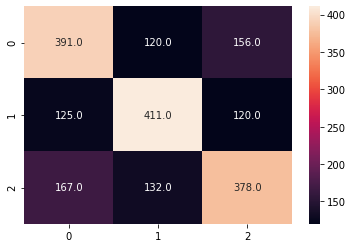

[0.02692209 0.0237373  0.02235915 0.0199686  0.01988984 0.01961623
 0.02007567 0.01816913 0.01941316 0.0155265  0.01782903 0.01452922
 0.01640285 0.01465045 0.01565238 0.01336463 0.01093732 0.01094481
 0.00903025 0.01025719 0.00864024 0.00911269 0.00824692 0.00812082
 0.00800405 0.00849318 0.00786906 0.00895579 0.00851117 0.00991197
 0.00949145 0.00831587 0.00826651 0.01071025 0.00802268 0.00781576
 0.00837029 0.00861926 0.00868951 0.00892965 0.00805335 0.00754502
 0.00818746 0.00745497 0.00840514 0.00798874 0.0093943  0.00783505
 0.00885603 0.0083006  0.00764257 0.00906086 0.00929299 0.00855285
 0.00931248 0.00802362 0.00780009 0.00845725 0.00846709 0.00743239
 0.00785306 0.00845954 0.00886057 0.0072168  0.00883858 0.00821504
 0.00873623 0.00915521 0.00811586 0.0077649  0.00766613 0.00808556
 0.00779837 0.00833081 0.00747979 0.00933649 0.00718771 0.00846449
 0.00820483 0.0092763  0.0085883  0.00771651 0.0070955  0.00820244
 0.00707941 0.00747586 0.00903338 0.00750377 0.00763956 0.0076

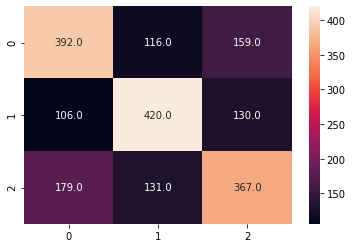

[0.03157678 0.02534936 0.02424435 0.02245033 0.02464653 0.0234781
 0.02380401 0.02241779 0.0208177  0.01929635 0.01932922 0.01665622
 0.01831947 0.0171913  0.01778739 0.01564971 0.0124412  0.01487592
 0.01201129 0.01157527 0.01090628 0.01004656 0.010696   0.01042125
 0.01033854 0.00966667 0.01045144 0.00950246 0.0107407  0.00948575
 0.00981041 0.01028113 0.00943359 0.01077557 0.01053747 0.00994728
 0.0104983  0.00975487 0.00917227 0.01044117 0.00985771 0.01097789
 0.01012552 0.01083642 0.01066983 0.01106871 0.00974296 0.00881751
 0.00967238 0.00917022 0.00979798 0.00973697 0.01001202 0.01109628
 0.00950091 0.01014485 0.01091855 0.00988077 0.00954057 0.00920077
 0.00924498 0.00988773 0.00991418 0.01118074 0.0098334  0.01041621
 0.00987181 0.01122445 0.00959021 0.01056723 0.01050842 0.01021334
 0.00864359 0.01031376 0.01064736 0.00954402 0.01096696 0.01009268
 0.01054558 0.00919854]
              precision    recall  f1-score   support

           0       0.58      0.59      0.58       6

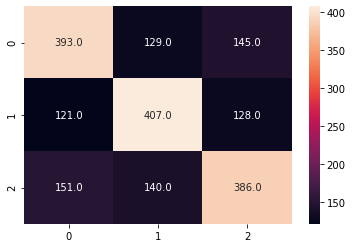

[0.03838972 0.03151394 0.02815314 0.03026976 0.02935557 0.02854329
 0.02881841 0.02694877 0.02704212 0.02273961 0.02564905 0.02262678
 0.02301727 0.02129175 0.02078735 0.01994825 0.01579618 0.01755662
 0.0153087  0.01571171 0.01315198 0.0118106  0.01378422 0.01426713
 0.01168688 0.01130637 0.01196373 0.01217422 0.01277948 0.01211139
 0.01139097 0.01371673 0.0129416  0.01367853 0.01263435 0.01319464
 0.01182934 0.01290127 0.01285401 0.01258889 0.01357289 0.01248605
 0.01350736 0.01203332 0.01226377 0.0132142  0.012506   0.01325185
 0.01348104 0.01364573 0.01543663 0.01215538 0.01325841 0.01204448
 0.01260751 0.01338337 0.01224448 0.01192919 0.01100206 0.01374202]
              precision    recall  f1-score   support

           0       0.59      0.59      0.59       667
           1       0.60      0.62      0.61       656
           2       0.59      0.57      0.58       677

    accuracy                           0.59      2000
   macro avg       0.59      0.59      0.59      2000
wei

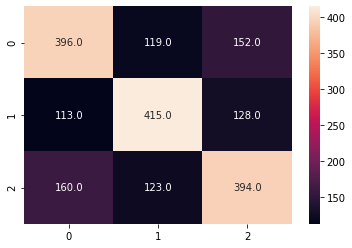

[0.04938854 0.03959667 0.03969969 0.03563381 0.03662485 0.03983959
 0.03809399 0.03618649 0.03691523 0.03537643 0.03073606 0.03019267
 0.02789757 0.02935981 0.02745965 0.02619693 0.0230253  0.02116865
 0.01981352 0.01929719 0.02007847 0.01633667 0.01715088 0.01966926
 0.01781417 0.01865377 0.01671886 0.01695864 0.01712954 0.01833686
 0.01682874 0.01872186 0.0176777  0.017911   0.01708654 0.01775755
 0.01823559 0.01783149 0.01718412 0.01941568]
              precision    recall  f1-score   support

           0       0.59      0.59      0.59       667
           1       0.63      0.63      0.63       656
           2       0.58      0.58      0.58       677

    accuracy                           0.60      2000
   macro avg       0.60      0.60      0.60      2000
weighted avg       0.60      0.60      0.60      2000

<bound method IndexOpsMixin.tolist of 0      98
5      42
2      24
1      11
6      50
8       6
4      37
7      60
3      61
9      20
10     86
11     72
13     74
12 

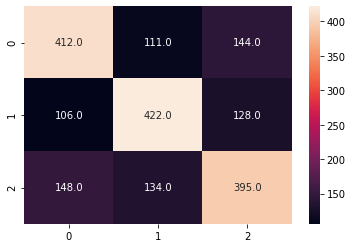

[0.05542117 0.03965202 0.04458394 0.04425375 0.0400591  0.03978442
 0.04176683 0.03948792 0.03833039 0.03554292 0.03204738 0.03448691
 0.03097383 0.03270046 0.0299585  0.02873202 0.02595187 0.02419982
 0.02047473 0.02005684 0.02061897 0.01988127 0.02350749 0.01820249
 0.01966042 0.02041791 0.02104552 0.02183037 0.01962621 0.02008993
 0.01991093 0.01932311 0.01933295 0.01864005 0.01944747]
              precision    recall  f1-score   support

           0       0.62      0.62      0.62       667
           1       0.63      0.64      0.64       656
           2       0.59      0.58      0.59       677

    accuracy                           0.61      2000
   macro avg       0.61      0.61      0.61      2000
weighted avg       0.61      0.61      0.61      2000

<bound method IndexOpsMixin.tolist of 0      98
2      24
3      11
6      37
4      50
5       6
1      42
7      60
8      61
9      20
11     72
13     62
10     86
12     74
14     87
15     34
16      2
17     63
22     13

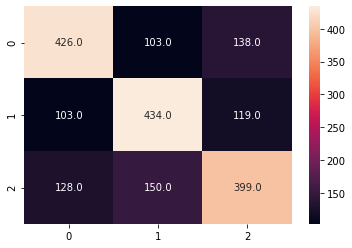

[0.05801597 0.0480275  0.04997859 0.04783265 0.04266948 0.04338897
 0.0451083  0.04288444 0.04488223 0.04059683 0.03622441 0.03328841
 0.03656924 0.03687572 0.03232222 0.03178697 0.02887038 0.02826478
 0.02311645 0.02200316 0.0230721  0.02176783 0.02452174 0.02366282
 0.02197658 0.02267506 0.022681   0.02100858 0.02281846 0.02310913]
              precision    recall  f1-score   support

           0       0.65      0.64      0.64       667
           1       0.63      0.66      0.65       656
           2       0.61      0.59      0.60       677

    accuracy                           0.63      2000
   macro avg       0.63      0.63      0.63      2000
weighted avg       0.63      0.63      0.63      2000

<bound method IndexOpsMixin.tolist of 0      98
2      11
1      24
3      37
6      42
8      61
5       6
7      60
4      50
9      20
13     74
12     86
10     72
11     62
14     87
15     34
16      2
17     63
22     53
23     40
18     13
29     55
20     15
28    106
26   

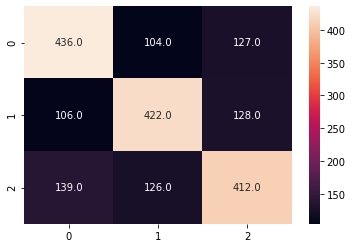

[0.06571726 0.05253641 0.05401748 0.05366557 0.05052672 0.05364484
 0.04853963 0.04683815 0.04932353 0.04706874 0.03868281 0.04260266
 0.04079571 0.03585687 0.0368867  0.03452166 0.03384953 0.02938702
 0.02797904 0.02672543 0.02773578 0.02586294 0.02547793 0.0243657
 0.0273919 ]
              precision    recall  f1-score   support

           0       0.64      0.65      0.65       667
           1       0.65      0.64      0.65       656
           2       0.62      0.61      0.61       677

    accuracy                           0.64      2000
   macro avg       0.64      0.64      0.64      2000
weighted avg       0.63      0.64      0.63      2000

<bound method IndexOpsMixin.tolist of 0      98
2      24
3      37
5      61
1      11
4      42
8      50
6       6
9      20
7      60
11     86
12     72
10     74
14     87
13     62
15     34
16      2
17     63
18     53
20     13
24     43
19     40
21     55
22     15
23    106
Name: feature, dtype: object>
20 0.6417604132294764

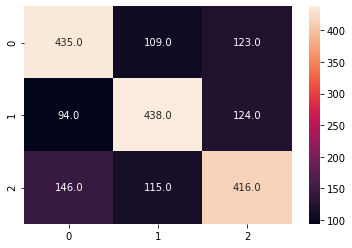

[0.07324472 0.06197531 0.06090367 0.05616258 0.0596594  0.05644983
 0.05600158 0.05792771 0.05064798 0.05508524 0.04900116 0.05029511
 0.04691353 0.04206808 0.04338656 0.04209984 0.03918869 0.03526589
 0.03191046 0.0318127 ]
              precision    recall  f1-score   support

           0       0.64      0.65      0.65       667
           1       0.66      0.67      0.66       656
           2       0.63      0.61      0.62       677

    accuracy                           0.64      2000
   macro avg       0.64      0.64      0.64      2000
weighted avg       0.64      0.64      0.64      2000

<bound method IndexOpsMixin.tolist of 0     98
1     24
2     37
4     11
7      6
5     42
3     61
6     50
9     60
8     20
11    72
10    86
12    74
14    62
15    34
13    87
16     2
17    63
18    53
19    13
Name: feature, dtype: object>
15 0.6388750119191571 0.6417604132294764


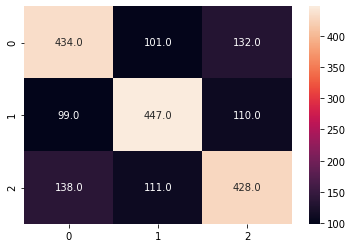

[0.085956   0.07346374 0.07364422 0.0728652  0.06857786 0.07117085
 0.07030632 0.07106968 0.06574943 0.06341726 0.06117121 0.05847706
 0.05902273 0.05437054 0.050738  ]
              precision    recall  f1-score   support

           0       0.65      0.65      0.65       667
           1       0.68      0.68      0.68       656
           2       0.64      0.63      0.64       677

    accuracy                           0.65      2000
   macro avg       0.65      0.65      0.65      2000
weighted avg       0.65      0.65      0.65      2000

10 0.5831832103849612 0.6417604132294764


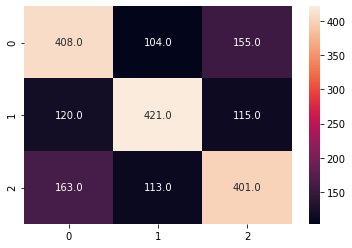

[0.11647309 0.09922401 0.10664216 0.10414842 0.09658254 0.09571207
 0.09717974 0.0952886  0.09595237 0.09279711]
              precision    recall  f1-score   support

           0       0.59      0.61      0.60       667
           1       0.66      0.64      0.65       656
           2       0.60      0.59      0.59       677

    accuracy                           0.61      2000
   macro avg       0.62      0.62      0.62      2000
weighted avg       0.62      0.61      0.62      2000

0.6417604132294764 20 

   feature  feature_importance
0       98            0.073245
1       24            0.061975
2       37            0.060904
4       11            0.059659
7        6            0.057928
5       42            0.056450
3       61            0.056163
6       50            0.056002
9       60            0.055085
8       20            0.050648
11      72            0.050295
10      86            0.049001
12      74            0.046914
14      62            0.043387
15      34       

In [41]:
y=df_y["Expected"]
scores_best=-1
k_feat=120
list_red_best=[]

xgb_c = XGBClassifier()
X_check=df.drop(columns=["Id"])
X_c_train, X_c_test, y_c_train, y_c_test = train_test_split(X_check, y, test_size=0.2, random_state=11)
xgb_c.fit(X_c_train, y_c_train)

scores_best=mean(cross_val_score(xgb_c, X_c_train, y_c_train, cv=5, scoring='f1_macro'))
print(k_feat,scores_best)
df_sorted=pd.DataFrame(
    {'feature': df.drop(columns=["Id"]).columns,
     'feature_importance': xgb_c.feature_importances_
    })
df_sorted=df_sorted.sort_values(by=["feature_importance"],ascending=False)
list_test=[100,80,60,40,35,30,25,20,15,10]
for k in list_test:
    list_red=df_sorted['feature'][0:k].to_list()
    X_check=df[list_red]
    X_c_train, X_c_test, y_c_train, y_c_test = train_test_split(X_check, y, test_size=0.2, random_state=11)
    xgb_c.fit(X_c_train, y_c_train)
    pred_xgb_c = xgb_c.predict(X_c_test)
    scores_c=mean(cross_val_score(xgb_c, X_c_train, y_c_train, cv=5, scoring='f1_macro'))
    print(k,scores_c,scores_best)
    cf_c = confusion_matrix(y_c_test, pred_xgb_c)
    sns.heatmap(cf_c, annot=True, fmt='.1f')
    plt.show()
    print(xgb_c.feature_importances_)
    print(classification_report(y_c_test, pred_xgb_c))
    df_features_temp=pd.DataFrame(
    {'feature': df_sorted['feature'][0:k].to_list(),
     'feature_importance': xgb_c.feature_importances_
    })
    df_sorted=df_features_temp.sort_values(by=["feature_importance"],ascending=False)
    if scores_c> scores_best:
        scores_best=scores_c
        k_feat=k
        list_red_best=df_sorted['feature'].to_list
        print (list_red_best)
        df_best=df_sorted
print(scores_best,k_feat,"\n")
print(df_best,"\n")
print(list_red_best,"\n")

In [42]:
df_best.to_csv("sorted_features_Final_rerun.csv")